# 基于改进蚁群算法优化的电商物流带容量限制的车辆路径问题（CVRP）
Author：Xukang Xie ，Zhejiang University of Technology   
Date：2025.06.07   
Datasets Name: large-scale-route-optimization   
Datasets From:  https://www.kaggle.com/datasets/mexwell/large-scale-route-optimization/data

## 1. 数据背景

- 制造公司有不同地点仓库，需规划订单配送中货物与卡车分配及卡车路线，目标是最小化总体配送成本。

约束条件  
1. **卡车容量**：可选择不同类型卡车，每种卡车有面积和重量容量限制，且假设各类卡车数量无限制。
2. **货物取用时间**：货物特定时间才可取用，卡车需等所分配货物都能取用时才能出发。
3. **时间差限制**：同一辆卡车中最早和最晚可取用货物的可用时间差小于用户定义限制（如4小时） 。 
4. **送达截止日期**：所有货物需在截止日期前送达目的地。
5. **货物兼容性**：根据产品特性，部分货物可同车运输，部分不行。 
6. **停车站点数量**：一辆卡车最多有用户定义数量（N）的停车站点。 
7. **停车站点停留时间与费用**：卡车在每个停车站点停留用户定义时长（M小时）卸货，每个停车站点除配送成本外还产生固定费用。 


## 2. 参数定义
数据集中缺少卡车相关参数，为了便于研究，添加了卡车参数。

### 2.1 卡车相关参数
1. **容量参数**
    - **小型卡车**：面积容量 10立方米，重量容量 3吨。
    - **中型卡车**：面积容量 20立方米，重量容量 5吨。
    - **大型卡车**：面积容量 35立方米，重量容量 8吨。
2. **成本参数**
    - **小型卡车**：每公里行驶成本 2元，每停一次车固定费用 50元/小时。
    - **中型卡车**：每公里行驶成本 3元，每停一次车固定费用 80元/小时。
    - **大型卡车**：每公里行驶成本 4元，每停一次车固定费用 100元/小时。

### 2.2 时间相关参数
1. **货物取用时间差限制**：同一辆卡车中最早和最晚可取用货物的可用时间差限制为 3小时 。
2. **停站点停留时间**：卡车在每个停车站点停留0.5小时来卸载货物 。
3. **卡车速度**：每公里行驶速度为 100km/h 。

### 2.3 数量限制参数
一辆卡车最多允许的停站点数量（N）为 10个 。 

```mermaid
flowchart TD
    A([开始]) --> B[初始化]
    B --> C[读取订单数据]
    C --> D[构建距离矩阵D]
    D --> E[初始化信息素矩阵τ=1]
    E --> F["计算启发值η = 1/(D+ε)"]
    
    subgraph 并行路径构造
        F --> G{迭代未完成?}
        G -- 是 --> H[parfor 每只蚂蚁a]
        H --> I[从depot出发]
        I --> J[轮盘赌选择下个节点]
        J --> K{检查约束?}
        K -- 通过 --> L[更新路径状态]
        K -- 不通过 --> M[返回depot]
        L --> J
        M --> N[记录路径成本]
        N --> G
    end
    
    subgraph 信息素更新
        G -- 否 --> O[全局信息素蒸发]
        O --> P["τ = (1-ρ)τ"]
        P --> Q[最优路径释放Δτ]
    end
    
    Q --> R{满足终止条件?}
    R -- 否 --> G
    R -- 是 --> S([输出最优路径集合])
```


## 3.数据准备


### 3.1 数据导入

In [1]:
#Lists of Library
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pulp
import math

In [2]:
distance = pd.read_csv("distance.csv")
orderl = pd.read_csv("order_large.csv")
orders = pd.read_csv("order_small.csv")

orderall=pd.concat([orders,orderl])
orderall.head(10)

,Order_ID,Material_ID,Item_ID,Source,Destination,Available_Time,Deadline,Danger_Type,Area,Weight
0,A140109,B-6128,P01-79c46a02-e12f-41c4-9ec9-25e48597ebfe,City_61,City_54,2022-04-05 23:59:59,2022-04-11 23:59:59,type_1,38880,30920000
1,A140112,B-6128,P01-84ac394c-9f34-48e7-bd15-76f92120b624,City_61,City_54,2022-04-07 23:59:59,2022-04-13 23:59:59,type_1,38880,30920000
2,A140112,B-6128,P01-b70c94db-630a-497b-bb63-b0ad86a7dce6,City_61,City_54,2022-04-07 23:59:59,2022-04-13 23:59:59,type_1,38880,30920000
3,A140112,B-6128,P01-4534a7e8-6d73-4a2e-8363-a6645d9bc345,City_61,City_54,2022-04-07 23:59:59,2022-04-13 23:59:59,type_1,38880,30920000
4,A140112,B-6128,P01-7208eb61-2cc1-4e7c-b698-e1ab2327b658,City_61,City_54,2022-04-07 23:59:59,2022-04-13 23:59:59,type_1,38880,30920000
5,A190223,B-6155,nan-4ac2f30e-bc0a-4415-8612-a6b38d833317,City_61,City_53,2022-04-06 23:59:59,2022-04-12 23:59:59,type_2,9840,7640000
6,A190225,B-6155,nan-5ae70ea9-a28e-4107-b267-5a6c84d4a3c7,City_61,City_53,2022-04-05 23:59:59,2022-04-11 23:59:59,type_2,9840,7640000
7,A190226,B-6155,nan-c9658637-b5f1-433d-885e-b3008612a73d,City_61,City_53,2022-04-07 23:59:59,2022-04-13 23:59:59,type_2,9840,7640000
8,A190226,B-6155,nan-75768ff3-3dde-4952-9aa0-594c373421d1,City_61,City_53,2022-04-07 23:59:59,2022-04-13 23:59:59,type_2,9840,7640000
9,A190226,B-6155,nan-39cdd29b-baee-4ed6-bec0-33227cc8608d,City_61,City_53,2022-04-07 23:59:59,2022-04-13 23:59:59,type_2,9840,7640000


### 3.2 数据清洗

In [3]:
distance.info()
orderall.info()
distance.isnull().sum(),orderall.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3782 entries, 0 to 3781
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Source       3782 non-null   object
 1   Destination  3782 non-null   object
 2   Distance(M)  3782 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 88.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 4645 entries, 0 to 4634
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Order_ID        4645 non-null   object
 1   Material_ID     4645 non-null   object
 2   Item_ID         4645 non-null   object
 3   Source          4645 non-null   object
 4   Destination     4645 non-null   object
 5   Available_Time  4645 non-null   object
 6   Deadline        4645 non-null   object
 7   Danger_Type     4645 non-null   object
 8   Area            4645 non-null   int64 
 9   Weight          4645 non-null   int64 
dtypes: 

(Source         0
 Destination    0
 Distance(M)    0
 dtype: int64,
 Order_ID          0
 Material_ID       0
 Item_ID           0
 Source            0
 Destination       0
 Available_Time    0
 Deadline          0
 Danger_Type       0
 Area              0
 Weight            0
 dtype: int64)

### 3.3 处理与拼接

#### 3.3.1 orderall处理

In [4]:

orderall['Available_Time']=orderall['Available_Time'].astype(str)
orderall['Deadline']=orderall['Deadline'].astype(str)

orderall['Available_Time']=orderall['Available_Time'].str[0:10]
orderall['Deadline']=orderall['Deadline'].str[0:10]
orderall['Available_Time']=pd.to_datetime(orderall['Available_Time'])
orderall['Deadline']=pd.to_datetime(orderall['Deadline'])

# Create new columns 'Leadtime(d)' and 'Route'
orderall['Leadtime(d)'] = (orderall['Deadline'] - orderall['Available_Time'])
orderall['Leadtime(d)'] =orderall['Leadtime(d)'].astype(str)
orderall['Leadtime(d)'] =orderall['Leadtime(d)'].str[0:1]
orderall['Leadtime(d)']=orderall['Leadtime(d)'].astype(int)
orderall['Route']=orderall['Source']+'_'+orderall['Destination']
orderall.head(10)

,Order_ID,Material_ID,Item_ID,Source,Destination,Available_Time,Deadline,Danger_Type,Area,Weight,Leadtime(d),Route
0,A140109,B-6128,P01-79c46a02-e12f-41c4-9ec9-25e48597ebfe,City_61,City_54,2022-04-05,2022-04-11,type_1,38880,30920000,6,City_61_City_54
1,A140112,B-6128,P01-84ac394c-9f34-48e7-bd15-76f92120b624,City_61,City_54,2022-04-07,2022-04-13,type_1,38880,30920000,6,City_61_City_54
2,A140112,B-6128,P01-b70c94db-630a-497b-bb63-b0ad86a7dce6,City_61,City_54,2022-04-07,2022-04-13,type_1,38880,30920000,6,City_61_City_54
3,A140112,B-6128,P01-4534a7e8-6d73-4a2e-8363-a6645d9bc345,City_61,City_54,2022-04-07,2022-04-13,type_1,38880,30920000,6,City_61_City_54
4,A140112,B-6128,P01-7208eb61-2cc1-4e7c-b698-e1ab2327b658,City_61,City_54,2022-04-07,2022-04-13,type_1,38880,30920000,6,City_61_City_54
5,A190223,B-6155,nan-4ac2f30e-bc0a-4415-8612-a6b38d833317,City_61,City_53,2022-04-06,2022-04-12,type_2,9840,7640000,6,City_61_City_53
6,A190225,B-6155,nan-5ae70ea9-a28e-4107-b267-5a6c84d4a3c7,City_61,City_53,2022-04-05,2022-04-11,type_2,9840,7640000,6,City_61_City_53
7,A190226,B-6155,nan-c9658637-b5f1-433d-885e-b3008612a73d,City_61,City_53,2022-04-07,2022-04-13,type_2,9840,7640000,6,City_61_City_53
8,A190226,B-6155,nan-75768ff3-3dde-4952-9aa0-594c373421d1,City_61,City_53,2022-04-07,2022-04-13,type_2,9840,7640000,6,City_61_City_53
9,A190226,B-6155,nan-39cdd29b-baee-4ed6-bec0-33227cc8608d,City_61,City_53,2022-04-07,2022-04-13,type_2,9840,7640000,6,City_61_City_53


#### 3.3.2 distance处理

In [5]:
## distance dataframe ##

#Create new columns 'Distance(km)', converting to kilometer
distance['Distance(km)']=(distance['Distance(M)']/1000).round(2)

#Create new columns 'Traveltime(hr)', converting from distance at speed 40km/hr to hr and day
distance['Deliverytime(hr)']=(distance['Distance(km)']/100).round(2) # truck limited speed 100km/hr
distance['Deliverytime(d)']=(distance['Deliverytime(hr)']/20).round(2) # 2shifts with OT 20hrs/day 

# Create new columns 'Leadtime(d)' and 'Route'
distance['Route']=distance['Source']+'_'+distance['Destination']

distance=distance.sort_values('Source',ascending=True).reset_index()
distance=distance.drop(columns=('index'))
distance.head(10)

,Source,Destination,Distance(M),Distance(km),Deliverytime(hr),Deliverytime(d),Route
0,City_0,City_47,1038299,1038.30,10.38,0.52,City_0_City_47
1,City_0,City_9,989513,989.51,9.90,0.50,City_0_City_9
2,City_0,City_34,1194717,1194.72,11.95,0.60,City_0_City_34
3,City_0,City_59,1434704,1434.70,14.35,0.72,City_0_City_59
4,City_0,City_16,1448352,1448.35,14.48,0.72,City_0_City_16
5,City_0,City_29,159218,159.22,1.59,0.08,City_0_City_29
6,City_0,City_8,354916,354.92,3.55,0.18,City_0_City_8
7,City_0,City_40,1200639,1200.64,12.01,0.60,City_0_City_40
8,City_0,City_11,685050,685.05,6.85,0.34,City_0_City_11
9,City_0,City_23,298902,298.90,2.99,0.15,City_0_City_23


为了计算交付时间，原始距离米将转换为千米。然后根据速度100千米/小时和每日工作时间20小时的设定，交付时间将分别转换为小时和天为单位。

#### 3.3.3 将orderall和distance拼接

In [24]:
data=pd.merge(orderall,distance,how='left',on='Route')

# Create new columns 'Weight(kg), converting to kilogram
data['Weight(kg)']=(data['Weight']/100000).round(2)

data=data.drop(columns=['Weight','Source_y', 'Destination_y', 'Distance(M)','Deliverytime(hr)'])
data=data.rename(columns={'Source_x':'Source', 'Destination_x': 'Destination'})
data.head(10)

,Order_ID,Material_ID,Item_ID,Source,Destination,Available_Time,Deadline,Danger_Type,Area,Leadtime(d),Route,Distance(km),Deliverytime(d),Weight(kg)
0,A140109,B-6128,P01-79c46a02-e12f-41c4-9ec9-25e48597ebfe,City_61,City_54,2022-04-05,2022-04-11,type_1,38880,6,City_61_City_54,2444.33,1.22,309.2
1,A140112,B-6128,P01-84ac394c-9f34-48e7-bd15-76f92120b624,City_61,City_54,2022-04-07,2022-04-13,type_1,38880,6,City_61_City_54,2444.33,1.22,309.2
2,A140112,B-6128,P01-b70c94db-630a-497b-bb63-b0ad86a7dce6,City_61,City_54,2022-04-07,2022-04-13,type_1,38880,6,City_61_City_54,2444.33,1.22,309.2
3,A140112,B-6128,P01-4534a7e8-6d73-4a2e-8363-a6645d9bc345,City_61,City_54,2022-04-07,2022-04-13,type_1,38880,6,City_61_City_54,2444.33,1.22,309.2
4,A140112,B-6128,P01-7208eb61-2cc1-4e7c-b698-e1ab2327b658,City_61,City_54,2022-04-07,2022-04-13,type_1,38880,6,City_61_City_54,2444.33,1.22,309.2
5,A190223,B-6155,nan-4ac2f30e-bc0a-4415-8612-a6b38d833317,City_61,City_53,2022-04-06,2022-04-12,type_2,9840,6,City_61_City_53,2458.22,1.23,76.4
6,A190225,B-6155,nan-5ae70ea9-a28e-4107-b267-5a6c84d4a3c7,City_61,City_53,2022-04-05,2022-04-11,type_2,9840,6,City_61_City_53,2458.22,1.23,76.4
7,A190226,B-6155,nan-c9658637-b5f1-433d-885e-b3008612a73d,City_61,City_53,2022-04-07,2022-04-13,type_2,9840,6,City_61_City_53,2458.22,1.23,76.4
8,A190226,B-6155,nan-75768ff3-3dde-4952-9aa0-594c373421d1,City_61,City_53,2022-04-07,2022-04-13,type_2,9840,6,City_61_City_53,2458.22,1.23,76.4
9,A190226,B-6155,nan-39cdd29b-baee-4ed6-bec0-33227cc8608d,City_61,City_53,2022-04-07,2022-04-13,type_2,9840,6,City_61_City_53,2458.22,1.23,76.4


## 定义车辆

In [5]:
class Vehicle:
    def __init__(self, size, volume_capacity, weight_capacity, cost_per_km, fixed_cost_per_hour):
        self.size = size                       # 类型
        self.volume_capacity = volume_capacity # 体积容量
        self.weight_capacity = weight_capacity # 重量容量
        self.cost_per_km = cost_per_km       # 每公里行驶成本
        self.fixed_cost_per_hour = fixed_cost_per_hour # 停车固定费用

# 定义车辆参数
vehicles = [
    Vehicle("小型", 10, 3000, 2, 50),  # 小型卡车
    Vehicle("中型", 20, 5000, 3, 80),  # 中型卡车
    Vehicle("大型", 35, 8000, 4, 100)  # 大型卡车
]


# Data Exploration and Visualization

In [ ]:
data.Source.unique() 

array(['City_61'], dtype=object)

city61是城市出发点

In [25]:
data.Destination.unique() # other 61 destinations

array(['City_54', 'City_53', 'City_45', 'City_31', 'City_19', 'City_12',
       'City_51', 'City_47', 'City_6', 'City_48', 'City_46', 'City_20',
       'City_55', 'City_39', 'City_17', 'City_5', 'City_15', 'City_27',
       'City_35', 'City_44', 'City_34', 'City_58', 'City_25', 'City_37',
       'City_13', 'City_14', 'City_4', 'City_16', 'City_28', 'City_57',
       'City_38', 'City_7', 'City_36', 'City_32', 'City_18', 'City_49',
       'City_52', 'City_50', 'City_10', 'City_3', 'City_26', 'City_8',
       'City_21', 'City_30', 'City_0', 'City_1', 'City_43', 'City_56',
       'City_60', 'City_33', 'City_41', 'City_59', 'City_2', 'City_23',
       'City_42', 'City_24', 'City_9', 'City_40', 'City_29', 'City_11',
       'City_22'], dtype=object)

# Model Optimization

In [17]:
#Scope the CVRP model by shipping date

## Create Shipping date (N day)
from datetime import datetime
data1=data.copy()
data1['Deadline']=data1['Deadline'].astype(str)
data1['Deadline date']=data1['Deadline'].str[0:10]
data1['Deadline date']=pd.to_datetime(data1['Deadline date'])
data1['Deliverytime(d)']=data1['Deliverytime(d)'].astype(int)
data1['Shipping date']=data1['Deadline date']-pd.to_timedelta(data1['Deliverytime(d)'], unit='d')- pd.Timedelta(days=1)
data1['Shipping date']=data1['Shipping date'].astype(str)
data1.head(3)

,Order_ID,Material_ID,Item_ID,Source,Destination,Available_Time,Deadline,Danger_Type,Area,Leadtime(d),Route,Distance(km),Deliverytime(d),Weight(kg),Deadline date,Shipping date
0,A140109,B-6128,P01-79c46a02-e12f-41c4-9ec9-25e48597ebfe,City_61,City_54,2022-04-05,2022-04-11,type_1,38880,6,City_61_City_54,2444.33,1,309.2,2022-04-11,2022-04-09
1,A140112,B-6128,P01-84ac394c-9f34-48e7-bd15-76f92120b624,City_61,City_54,2022-04-07,2022-04-13,type_1,38880,6,City_61_City_54,2444.33,1,309.2,2022-04-13,2022-04-11
2,A140112,B-6128,P01-b70c94db-630a-497b-bb63-b0ad86a7dce6,City_61,City_54,2022-04-07,2022-04-13,type_1,38880,6,City_61_City_54,2444.33,1,309.2,2022-04-13,2022-04-11


In [19]:
# Select first shipment date to run the model 
data1=data1.loc[data1['Shipping date']=='2022-04-05']
data1.head(3)

,Order_ID,Material_ID,Item_ID,Source,Destination,Available_Time,Deadline,Danger_Type,Area,Leadtime(d),Route,Distance(km),Deliverytime(d),Weight(kg),Deadline date,Shipping date
3127,A250122,Y-003L,6257d149-f91f-4739-a69d-113a7a95a347,City_61,City_50,2022-04-05,2022-04-06,non_danger,8588,1,City_61_City_50,60.08,0,52.3,2022-04-06,2022-04-05
3128,A250122,Y-003L,80a8c5ca-08c4-46f9-8e6f-39f03cb3a3c1,City_61,City_50,2022-04-05,2022-04-06,non_danger,8588,1,City_61_City_50,60.08,0,52.3,2022-04-06,2022-04-05
3129,A250122,Y-003L,d6506c35-ae79-4c11-bfbc-08c8bbcc0b88,City_61,City_50,2022-04-05,2022-04-06,non_danger,8588,1,City_61_City_50,60.08,0,52.3,2022-04-06,2022-04-05


In [6]:
# CVRP, define dataset and vehicle capacity at 10000 kg/truck

vrp=data1.copy()
# 定义车型及容量
vehicles = [
    {'type': 'Small', 'weight_cap': 3000, 'volume_cap': 10, 'cost_per_km': 2, 'fixed_cost': 50},
    {'type': 'Medium', 'weight_cap': 5000, 'volume_cap': 20, 'cost_per_km': 3, 'fixed_cost': 80},
    {'type': 'Large', 'weight_cap': 8000, 'volume_cap': 35, 'cost_per_km': 4, 'fixed_cost': 100}
]

# 修改模型以支持多车型选择
problem = pulp.LpProblem('CVRP_Multi_Vehicle', pulp.LpMinimize)
x = pulp.LpVariable.dicts('x', [(v, i, j) for v in range(len(vehicles)) for i in range(n_point) for j in range(n_point)], cat='Binary')



df=vrp.groupby('Destination')['Weight(kg)'].sum()
df=pd.DataFrame(df).reset_index()
df['N_vehicle']=(df['Weight(kg)']/10000).apply(math.ceil)
df['Demandpertruck']=(df['Weight(kg)']/df['N_vehicle']).apply(math.ceil)
df['order']=df['Destination'].str[5:7]
df['order']=df['order'].astype(int)

df=df.sort_values('order',ascending=True).reset_index()
df=df.drop(columns=['order','index'])

df

NameError: name 'data1' is not defined

> Create new dataframe to **group destinations with weight(kg) as demand**. However, at City_19, the volume is over than one truck which is better to ship directly to destination. So, it will be removed from this routing model.

In [35]:
# truck >1 : Direct delivery, =1 : Milk-run deliver

# Only drop index 3 if it exists
if 3 in df.index:
	df = df.drop(index=[3]).reset_index(drop=True)

n_customer = len(df)
n_point = n_customer + 1

df['coordX'] = np.random.randint(1, 100, n_customer)
df['coordY'] = np.random.randint(1, 100, n_customer)

df

,Destination,Weight(kg),N_vehicle,Demandpertruck,coordX,coordY
0,City_49,1860.0,1,1860,79,62
1,City_50,2200.2,1,2201,93,34


> After removing City_19, then set variables for **no. of destination, depot and coordinates**. However, there is no actual coordinates from current data, so they are simulated to vistualize route at the end of result.

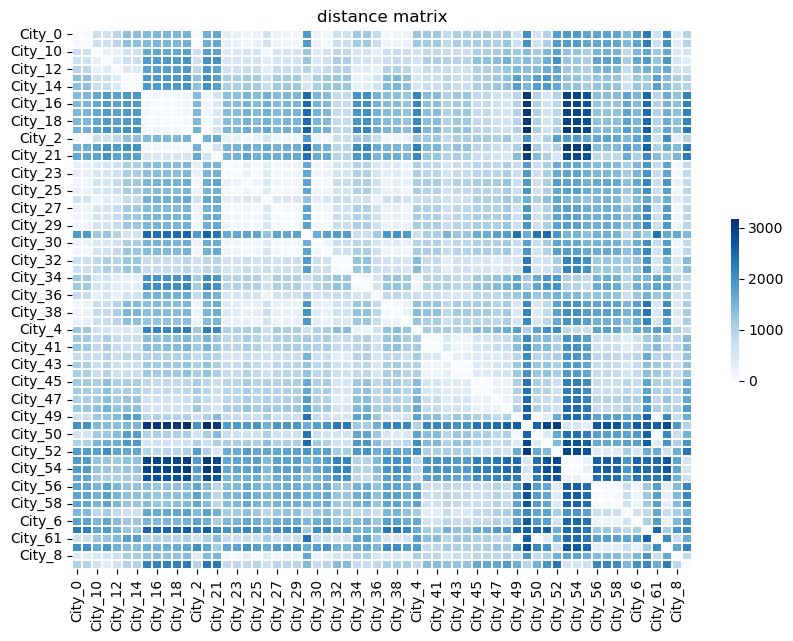

In [32]:
# Distance Matrix
distance['Distance(km)']=distance['Distance(km)'].astype(int)
distances=distance.pivot(index='Source', columns='Destination', values='Distance(km)').rename_axis(index=None, columns=None)
distances=distances.fillna(0)
# distances=np.array(distances)
distances=pd.DataFrame(distances)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=False, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('distance matrix')
plt.show()

In [ ]:
distances

,City_0,City_1,City_10,City_11,City_12,City_13,City_14,City_15,City_16,City_17,...,City_56,City_57,City_58,City_59,City_6,City_60,City_61,City_7,City_8,City_9
City_0,0.0,47.0,721.0,685.0,922.0,1344.0,1344.0,1407.0,1448.0,1443.0,...,1712.0,1756.0,1707.0,1434.0,1763.0,2249.0,634.0,2016.0,354.0,989.0
City_1,50.0,0.0,700.0,664.0,902.0,1323.0,1324.0,1431.0,1472.0,1467.0,...,1697.0,1741.0,1692.0,1415.0,1749.0,2229.0,674.0,2002.0,335.0,968.0
City_10,719.0,700.0,0.0,270.0,263.0,684.0,683.0,1654.0,1675.0,1667.0,...,1495.0,1541.0,1476.0,875.0,1442.0,1690.0,1210.0,1661.0,479.0,600.0
City_11,683.0,664.0,270.0,0.0,362.0,744.0,747.0,1848.0,1869.0,1861.0,...,1736.0,1783.0,1718.0,1117.0,1684.0,1868.0,1264.0,1903.0,572.0,351.0
City_12,920.0,900.0,261.0,361.0,0.0,429.0,428.0,1762.0,1768.0,1760.0,...,1461.0,1507.0,1442.0,817.0,1408.0,1545.0,1419.0,1614.0,688.0,622.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
City_60,2247.0,2228.0,1690.0,1865.0,1544.0,1200.0,1197.0,2519.0,2461.0,2496.0,...,1188.0,1216.0,1177.0,844.0,1018.0,0.0,2494.0,1120.0,1910.0,2102.0
City_61,635.0,671.0,1210.0,1265.0,1420.0,1783.0,1782.0,915.0,1006.0,993.0,...,1759.0,1776.0,1754.0,1704.0,1819.0,2527.0,0.0,2064.0,748.0,1569.0
City_7,2018.0,2006.0,1616.0,1880.0,1555.0,1369.0,1369.0,1635.0,1535.0,1573.0,...,324.0,332.0,330.0,774.0,258.0,1123.0,2069.0,0.0,1683.0,2182.0
City_8,394.0,375.0,481.0,576.0,691.0,1098.0,1098.0,1282.0,1324.0,1316.0,...,1380.0,1424.0,1375.0,1087.0,1432.0,1910.0,756.0,1685.0,0.0,880.0


> Create **distance matrix** by pivoting from the distance dataset earlier. This matrix will be used to calculate distance with the selected routes for the model optimization.

In [ ]:
#Add depot to df at index 0 
depot = {
    'Destination': {'': 'City_61'},
    'Weight(kg)': {'': 0},
    'N_vehicle': {'': 0},
    'Demandpertruck': {'': 0},
    'coordX': {'': 0},
    'coordY': {'': 0}}
depot=pd.DataFrame(depot)
df=pd.concat([depot,df]).reset_index()
df=df.drop(columns=('index'))
df

,Destination,Weight(kg),N_vehicle,Demandpertruck,coordX,coordY
0,City_61,0.0,0,0,0,0
1,City_15,2600.0,1,2600,2,23
2,City_17,5328.0,1,5328,37,95
3,City_18,2154.6,1,2155,2,44
4,City_35,2596.0,1,2596,69,70
5,City_48,7512.0,1,7512,57,37
6,City_49,1860.0,1,1860,75,6
7,City_50,2200.2,1,2201,74,32
8,City_57,5040.0,1,5040,97,44
9,City_59,1397.4,1,1398,47,20


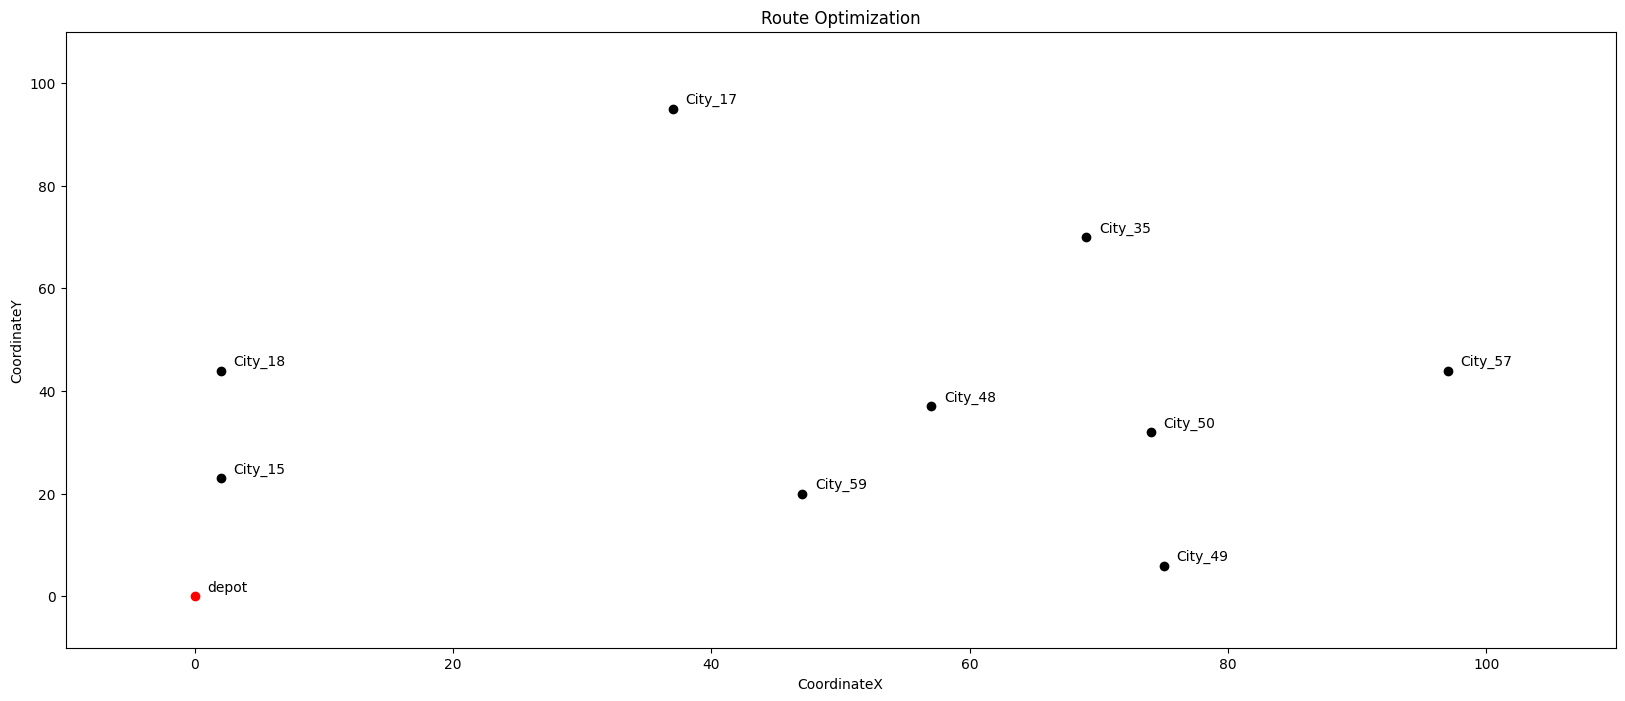

In [ ]:
#Plot locations

plt.figure(figsize=(20, 8))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['coordX'], row['coordY'], c='r')
        plt.text(row['coordX'] + 1, row['coordY'] + 1, 'depot')
    else:
        plt.scatter(row['coordX'], row['coordY'], c='black')
        demand = row['Demandpertruck']
        plt.text(row['coordX'] + 1, row['coordY'] + 1, row['Destination'])
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('Route Optimization')
plt.xlabel('CoordinateX')
plt.ylabel('CoordinateY')
plt.show()

> Visualize locations, ploted by the **simulated coordinates** and change City_61 as red depot.

In [36]:
# Integer linear progamming, to find minimize total distances

demands = df['Weight(kg)'].values
# Set problem
problem = pulp.LpProblem('CVRP_with_Capacity', pulp.LpMinimize)

# Decision variables
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(n_point) for j in range(n_point)),
                         lowBound=0, upBound=1, cat='Binary')
n_vehicle = pulp.LpVariable('n_vehicle', lowBound=0, upBound=100, cat='Integer')

# MTZ variables for capacity constraints
u = pulp.LpVariable.dicts('u', (i for i in range(n_point)),
                         lowBound=0, upBound=vehicle_capacity, cat='Continuous')

# Map the original Source/Destination names to the new integer indices (0 to n_point-1)
# The first entry in df is the depot (index 0)
index_mapping = {city: i for i, city in enumerate(df['Destination'])}

# Create a new distance matrix using the integer indices
# Initialize a matrix of zeros with dimensions n_point x n_point
indexed_distances = np.zeros((n_point, n_point))

# Fill the indexed_distances matrix using the original distances DataFrame and the index_mapping
# The distances DataFrame uses Source and Destination names as index and columns
for i in range(n_point):
    for j in range(n_point):
        # Get the city names corresponding to the integer indices i and j
        source_city = df['Destination'].iloc[i]
        destination_city = df['Destination'].iloc[j]

        # Look up the distance in the original distances DataFrame
        # Need to handle the case where the Source and Destination are the same (distance is 0)
        if source_city in distances.index and destination_city in distances.columns:
             indexed_distances[i, j] = distances.loc[source_city, destination_city]


# Objective function: minimize total distance using the indexed_distances
problem += pulp.lpSum([indexed_distances[i, j] * x[i, j] for i in range(n_point) for j in range(n_point)])


# Constraints

# 1. No self-loops
for i in range(n_point):
    problem += x[i, i] == 0

# 2. Flow constraints
for i in range(1, n_point):  # Customers only
    problem += pulp.lpSum(x[j, i] for j in range(n_point)) == 1  # Exactly one incoming
    problem += pulp.lpSum(x[i, j] for j in range(n_point)) == 1  # Exactly one outgoing

# 3. Depot constraints
problem += pulp.lpSum(x[0, i] for i in range(1, n_point)) == n_vehicle  # Vehicles leave depot
problem += pulp.lpSum(x[i, 0] for i in range(1, n_point)) == n_vehicle  # Vehicles return to depot

# 4. Capacity constraints using MTZ formulation
for i in range(1, n_point):
    problem += u[i] >= demands[i]  # Each customer must receive at least its demand. demands[0] is depot demand.
    problem += u[i] <= vehicle_capacity  # Cannot exceed vehicle capacity

# 修正MTZ约束（以单一车型为例）
for v in range(len(vehicles)):
    for i in range(n_point):
        for j in range(1, n_point):
            if i != j:
                problem += u[j] >= u[i] + demands[j] - (1 - x[v, i, j]) * vehicles[v]['weight_cap']
                problem += u[j] <= vehicles[v]['weight_cap']


# Solve the problem
status = problem.solve()

# Output solution status
print("Status:", pulp.LpStatus[status])
print("Total distance:", pulp.value(problem.objective))
print("Number of vehicles used:", pulp.value(n_vehicle))




IndexError: single positional indexer is out-of-bounds

In [ ]:
# Extract result to DataFrame

# Extract and display routes
# Modified function to directly use the numerical values in x_sol
def extract_routes(x_sol, n_point):
    routes = []
    for v in range(len(vehicles)):
        for i in range(n_point):
            if x_sol[v, 0, i] == 1:  # 车辆从仓库出发
                current = i
                route = [0, current]
                while True:
                    next_node = None
                    for j in range(n_point):
                        if x_sol[v, current, j] == 1 and j != current:
                            next_node = j
                            break
                    if next_node == 0:  # 返回仓库
                        route.append(0)
                        break
                    route.append(next_node)
                    current = next_node
                routes.append(route)
    return routes


# Convert x variables to a 2D array of numerical values
x_sol_values = [[x[i,j].varValue if x[i,j].varValue is not None else 0 for j in range(n_point)] for i in range(n_point)]
routes = extract_routes(x_sol_values, n_point)

# Create a mapping from index to destination name
index_to_destination = {i: city for i, city in enumerate(df['Destination'])}

results = []
for i, route in enumerate(routes, 1):
    # Convert route indices to destination names
    route_str = ">".join(index_to_destination[node] for node in route)


    # Calculate route statistics
    distance = sum(indexed_distances[route[k], route[k+1]] for k in range(len(route)-1))
    weight = sum(demands[node] for node in route if node != 0)  # demands[0] is for depot, skip it

    results.append({
        'Truck': f'Truck{i}',
        'Route': route_str,
        'Weight(kg)': weight,
        'Distance(km)': distance,
        'Cost': distance * 3,  # Assuming $3 per km
        'Capacity_Used(%)': ((weight/vehicle_capacity)*100).round(2),
    })

# Add summary row
total_distance = sum(r['Distance(km)'] for r in results)
total_weight = sum(r['Weight(kg)'] for r in results)
total_cost = sum(r['Cost'] for r in results)

results.append({
    'Truck': 'Sum Total',
    'Route': '',
    'Weight(kg)': total_weight,
    'Distance(km)': total_distance,
    'Cost': total_cost,
    'Capacity_Used(%)': '',
})

# Create DataFrame
results_df = pd.DataFrame(results)
results_df

,Truck,Route,Weight(kg),Distance(km),Cost,Capacity_Used(%)
0,Truck1,City_61>City_15>City_17>City_61,7928.0,2003.0,6009.0,79.28
1,Truck2,City_61>City_48>City_18>City_61,9666.6,2585.0,7755.0,96.67
2,Truck3,City_61>City_49>City_50>City_61,4060.2,119.0,357.0,40.6
3,Truck4,City_61>City_57>City_59>City_35>City_61,9033.4,5206.0,15618.0,90.33
4,Sum Total,,30688.2,9913.0,29739.0,


> To have readable result, the result is extracted to dataframe and list of **key results: routes, weight, distance, cost ($3/km) and capacity used%. The optimal result is total 9,913.0 km with 4 trucks**. 

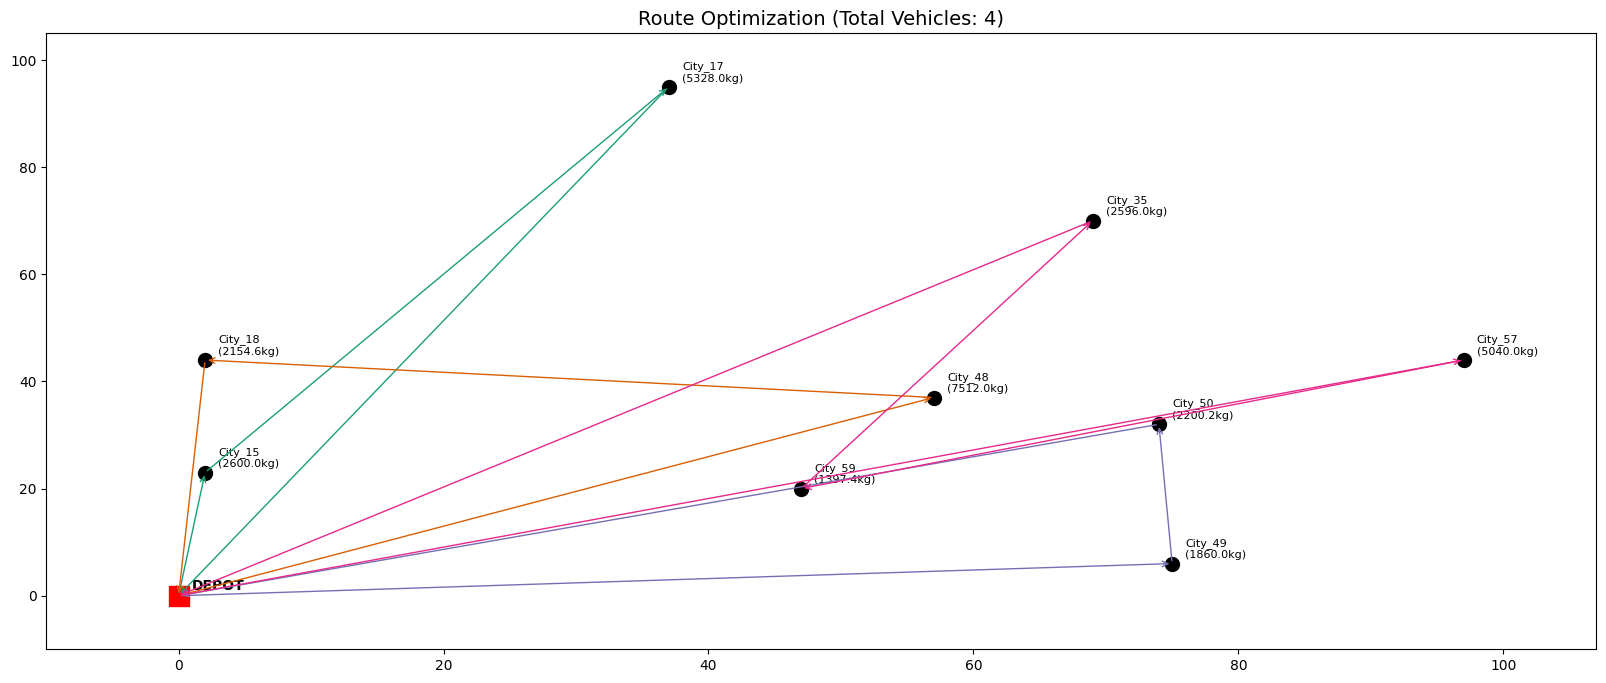

In [ ]:
# Route Visualization

plt.figure(figsize=(20, 8))

# Draw all locations
for i, row in df.iterrows():
    if i == 0:
        # Depot
        plt.scatter(row['coordX'], row['coordY'], c='r', s=200, marker='s')
        plt.text(row['coordX'] + 1, row['coordY'] + 1, 'DEPOT', fontsize=10, weight='bold')
    else:
        # Customers
        plt.scatter(row['coordX'], row['coordY'], c='black', s=100)
        demand = row['Weight(kg)']
        plt.text(row['coordX'] + 1, row['coordY'] + 1, 
                f'{row["Destination"]}\n({demand:.1f}kg)', 
                fontsize=8)

plt.xlim([min(df['coordX'])-10, max(df['coordX'])+10])
plt.ylim([min(df['coordY'])-10, max(df['coordY'])+10])
plt.title(f'Route Optimization (Total Vehicles: {int(pulp.value(n_vehicle))})', fontsize=14)


# draw optimal route
cmap = plt.colormaps['Dark2']
routes = [(i, j) for i in range(n_point) for j in range(n_point) if pulp.value(x[i, j]) == 1]

for v in range(int(pulp.value(n_vehicle))):
    
    # identify the route of each vehicle
    # Assuming the first segment of each vehicle's route starts from the new depot (x)
    vehicle_route = [route for route in routes if route[0] == 0][v:v+1]

    # while vehicle_route[-1][1] != 0: # New depot at index (x)
    while vehicle_route[-1][1] != 0: 
        for p in routes:
            if p[0] == vehicle_route[-1][1]:
                vehicle_route.append(p)
                break

    # draw for each vehicle
    arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor=cmap(v))
    for i, j in vehicle_route:
        plt.annotate('', xy=[df.iloc[j]['coordX'], df.iloc[j]['coordY']], xytext=[df.iloc[i]['coordX'], df.iloc[i]['coordY']], arrowprops=arrowprops)

plt.show()

> Here is the simulated **route visualization**. The coordinates are random, so the routes will be changed every run-time. It's better to have some actual coordinates for the further studies.

# Conclusion

> **Capacitated Vehicle Routing Problem (CVRP)** is one of the powerful methods to solve this kind of problem. Here is a small project covering only specific area. There are plenty of varialbels and contraints and more angles to play with the model. For Python, there are many interesting libraries other than **PuLP like PyVRP, ortools and many more**. So, it would be challenging to explore more. Thank you for reading till the end and happy to hear any feedback and suggestions. :)